# DESAFIO IV - Parte 2
# Clasificación de accidentes de tráfico
#### Grupo 5
Alexandra Binder y Verónica Nieves

---
## Introducción

**Contexto**


Existen distintos factores que, en conjunto se ven involucrados en el origen de los accidentes automovilísticos. Por ejemplo: el clima, las características del conductor, las especificaciones del automóvil, entre otros. El presente dataset es producto del registro manual de los accidentes de tráfico del periodo 2017 - 2020 de la ciudad **Addis Ababa**, ciudad capital de Ethiopia. La información fue recopilada por los departamentos de policía y posteriormente utilizada con fines de inventigación. Toda la información sensible ha sido excluida durante la transcripción de los datos desde los regitros manuales hasta la creación del archivo CSV. Finalmente se tienen 32 features y 12.316 registros de accidentes.

<br>
<img src="image/mapa_addis.png" alt="position-map" width="300"/>

Los datos se encuentran disponibles en:
https://www.kaggle.com/datasets/saurabhshahane/road-traffic-accidents


Este dataset fue seleccionado porque nos resulta interesante conocer cuáles son los distintos aspectos que influyen en la gravedad de un accidente automovilístico, y cómo estos interactúan entre sí. 

Queremos identificar cuáles son las características que tienen mayor influencia al momento de definir la gravedad de un accidente de tránsito, para luego obtener un modelo que prediga con mayor facilidad la gravedad de las heridas _(ligeras, graves, fatales)_ que se puedan ocasionar en accidentes de automovilísticos futuros. Esto permitirá identificar las condiciones que los conductores deben cumplir y/o evitar para **prevenir** accidentes con heridas fatales.

### **Objetivos del Desafío 3**
- **Explorar y limpiar en dataset**
- **Balancear el dataset respecto a la variable target: `Accident_severity`**
- **Predecir la variable target con al menos tres modelos de clasificación.**
- **Evaluar la performance de los modelos y comparar ventajas y desventajas de cada modelo.**
- **Determinar e interpretar la importancia de las features incluidas en la predicción.**

---
<a id="contenido"></a> 
## **Índice**

- [Módulo 1. Exploración y limpieza (parte 1)](#intro)
- [Módulo 2. Análisis exploratorio y selección de features](#m2)
- [Módulo 3. Balance de clases](#m3)
- [Módulo 4. Modelos de clasificación](#m4)
    - [4.1. Modelo de Regresión Logística](#mod_reg_log)
    - [4.2. Modelo Random forest](#random_forest)
    - [4.3. Modelo Gradient Boosting](#gradient_boosting)
    - [4.4. Modelo XGBoost](#xgboost)
- [Módulo 5 - Comparación de resultados y Conclusión](#m5)
   

---
<a id="m2"></a> 
## Módulo 2 - Análisis exploratorio y selección de features
[Ir a índice](#contenido)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import squarify

from statistics import variance
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Partimos del dataset resultante de la parte 1, donde limpiamos el dataset original. En esta segunda parte, buscamos analizar cómo interactúan las variables entre sí y con cada una de las categorías de la feature objetivo.

La parte 1.a del trabajo contiene un dataset manteniendo la mayoría de las features como categóricas, mientras que la parte 1.b contiene features con conversiones de variable categórica a numérica; este último va a ser utilizado para el entrenamiento de los modelos y para realizar el análisis de las variables numéricas en este módulo.

In [2]:
data = pd.read_csv("RTA_clean.csv", index_col=False)
print("Tamaño del dataset: ", data.shape[0], " registros y ", data.shape[1], " columnas.\n")
data.head(2)

Tamaño del dataset:  12138  registros y  23  columnas.



,Day_of_week,Age_band_of_driver,Sex_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Service_year_of_vehicle,Defect_of_vehicle,Lanes_or_Medians,...,Type_of_collision,Number_of_vehicles_involved,Number_of_casualties,Vehicle_movement,Casualty_class,Casualty_severity,Pedestrian_movement,Cause_of_accident,Accident_severity,Hour
0,Monday,Young_Adult,Male,Advanced,Employee,Beginner,Automobile,Advanced_Exp,No defect,Unknown,...,Inanimated_Objects,2,2,Forward,Unknown,0,No_pedestrian,Other,Slight Injury,17
1,Monday,Adult,Male,Middle,Employee,Expert,Public,Advanced_Exp,No defect,Undivided_Two-way,...,Vehicles,2,2,Forward,Unknown,0,No_pedestrian,Other,Slight Injury,17


In [3]:
data_num = pd.read_csv("RTA_clean_model.csv", index_col=False)
print("Tamaño del dataset: ", data_num.shape[0], " registros y ", data_num.shape[1], " columnas.\n")
data_num.head(2)

Tamaño del dataset:  12138  registros y  23  columnas.



,Day_of_week,Age_band_of_driver,Educational_level,Vehicle_driver_relation,Driving_experience,Type_of_vehicle,Service_year_of_vehicle,Known_defect_information,Lanes_or_Medians,Types_of_Junction,...,Number_of_vehicles_involved,Number_of_casualties,Vehicle_movement,Casualty_class,Casualty_severity,Pedestrian_movement,Cause_of_accident,Accident_severity,Hour,Sex_driver_Male
0,1,2,3,Employee,1,Automobile,3,1,Unknown,No_junction,...,2,2,Forward,Unknown,0,0,Other,Slight Injury,17,1
1,1,3,2,Employee,4,Public,3,1,Undivided_Two-way,No_junction,...,2,2,Forward,Unknown,0,0,Other,Slight Injury,17,1


Comenzamos por visualizar el tipo de severidad de los accidentes, es decir, con que frecuencia se presenta cada clase de `Accident_severity`.

,Accident_severity
Slight Injury,10256
Serious Injury,1725
Fatal injury,157


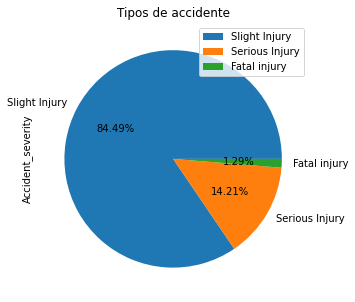

In [4]:
# Gráfico circular la feature objetivo
sns.color_palette("hls", 8)
# Cambiar a lightmode para ver titulo
plot = data['Accident_severity'].value_counts().plot(kind='pie', autopct='%.2f%%', figsize=(5, 5), title="Tipos de accidente")
plot.legend(data['Accident_severity'].value_counts().index)
plot.set_facecolor("white")

# valor por categoría
acc_sev = pd.DataFrame(data['Accident_severity'].value_counts())
acc_sev

Como se habia comentado anteriormente, tenemos tres clases desbalanceadas. La clase _Fatal injury_ tan solo representa el 1.29% de los datos. Es la clase minoritaria, pero quizá la más importante de predecir, pues conocer las condiciones que originan un accidente de gravedad fatal puede ser útil para prevenir este tipo de accidentes a futuro.

Visualizamos la distribución de accidentes a lo largo del dia, según la hora en la que ocurrieron.

[Text(0.5, 1.0, 'Cantidad de accidentes por hora')]

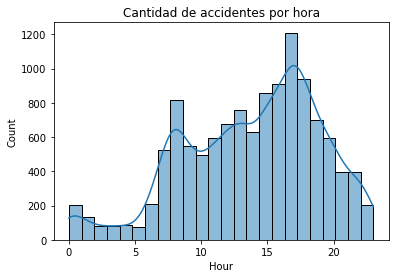

In [5]:
# gráfico de barras de hours
sns.histplot(data=data, x="Hour", kde=True, bins=24).set(title='Cantidad de accidentes por hora')

In [6]:
# Calculamos la variación absoluta en la hora anterior y posterior a los valores máximos de la curva.
hour_count = [(data['Hour'] == 7).sum(), (data['Hour'] == 8).sum(), (data['Hour'] == 9).sum(), 
              (data['Hour'] == 15).sum(), (data['Hour'] == 16).sum(), (data['Hour'] == 17).sum()]

print("Count at 7:00 = ", hour_count[0])
print("Count at 8:00 = ", hour_count[1])
print("Count at 9:00 = ", hour_count[2])
print("Promedio absoluto de diferencia entre (7:00 y 8:00) y (8:00 y 9:00) = ", np.abs(np.mean([hour_count[0]-hour_count[1], hour_count[2]-hour_count[1]])))

print("\nCount at 15:00 = ", hour_count[3])
print("Count at 16:00 = ", hour_count[4])
print("Count at 17:00 = ", hour_count[5])
print("Promedio absoluto de diferencia entre (15:00 y 16:00) y (16:00 y 17:00) = ", np.abs(np.mean([hour_count[3]-hour_count[4], hour_count[5]-hour_count[4]])))

Count at 7:00 =  524
Count at 8:00 =  819
Count at 9:00 =  550
Promedio absoluto de diferencia entre (7:00 y 8:00) y (8:00 y 9:00) =  282.0

Count at 15:00 =  859
Count at 16:00 =  912
Count at 17:00 =  1210
Promedio absoluto de diferencia entre (15:00 y 16:00) y (16:00 y 17:00) =  122.5


Se observa que la cantidad de accidentes es mínima entre las 23:00 y las 06:00 de la mañana, lo cual es esperable ya que durante este horario, la mayoría de la población duerme. La cantidad de accidentes aumenta a medida en que se extiende el horario laboral y disminuye a medida en que finaliza la jornada. Se observan dos máximos en la curva: a las 08:00 y a las 16:00, siendo este último el horario con mayor cantidad de accidentes. Estos puntos máximos se diferencia por una cantidad de 282 y 122 registros con los horarios contiguos, respectivamente.

Para comprender mejor nuestra variable objetivo, análizamos cómo se distribuye cada categoría de `Accident_severity` a lo largo del día.

[Text(0.5, 1.0, 'Distribución de tipo de accidentes por hora')]

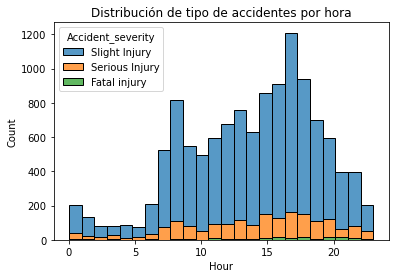

In [7]:
sns.histplot(data=data, x="Hour", hue="Accident_severity", multiple="stack", bins=24).set(title="Distribución de tipo de accidentes por hora")

Observemos que la presencia de accidentes fatales es baja durante todo el día, sin embargo, esta categoría tiene mayor presencia entre las 15:00 y las 23:00 hrs. Pero, ¿comó varía la cantidad de accidentes a lo largo de la semana?, veamos:

In [8]:
# Ordenamos días de la semana
sorted_days = pd.DataFrame(data['Day_of_week'].value_counts())
sorted_days["order"] = [5, 4, 3, 2, 1, 6, 7]
sorted_days = sorted_days.sort_values("order")

sorted_fatal_days = pd.DataFrame(data[data['Accident_severity'] == 'Fatal injury']['Day_of_week'].value_counts())
sorted_fatal_days["order"] = [6, 7, 4, 3, 2, 5, 1]
sorted_fatal_days = sorted_fatal_days.sort_values("order")

[Text(0.5, 1.0, 'Cantidad de accidentes fatales por día de la semana')]

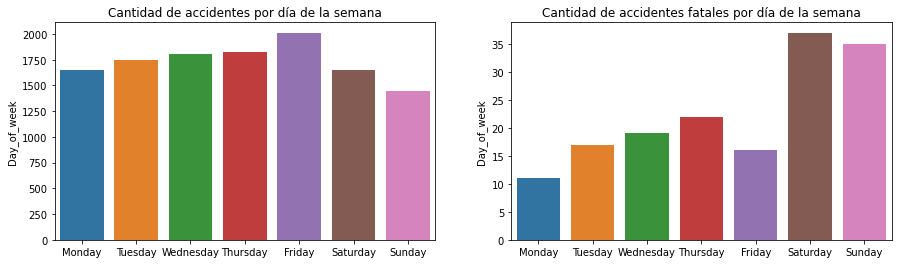

In [9]:
# gráfico de barras de frecuencias relativas.
plt.subplots(1,2,figsize=(15,4))
plt.subplot(1, 2, 1)
sns.barplot(x=sorted_days.index, y="Day_of_week", data=sorted_days).set(title="Cantidad de accidentes por día de la semana")
plt.subplot(1, 2, 2)
sns.barplot(x=sorted_fatal_days.index, y="Day_of_week", data=sorted_fatal_days).set(title="Cantidad de accidentes fatales por día de la semana")

Se observa que el día más propenso a accidentes es el día viernes, mientras que el día menos propenso es el domingo. Esto puede deberse a que los días viernes, cuando termina la semana laboral, las personas tienden a salir a diferentes eventos sociales (particularmente nocturnos), mientras que los domingos suelen ser días relativamente tranquilos y de descanso. Sin embargo, si analizamos los días en los que ocurren la mayor cantidad de accidentes fatales, los resultados contrastan contra el primer gráfico: los días con mayor cantidad de accidentes fatales son los sábados y los domingos.

Ahora, veamos cuáles son las caracteristicas de los conductores y los vehículos.

[Text(0.5, 1.0, 'Distribución de nivel educativo de los conductores')]

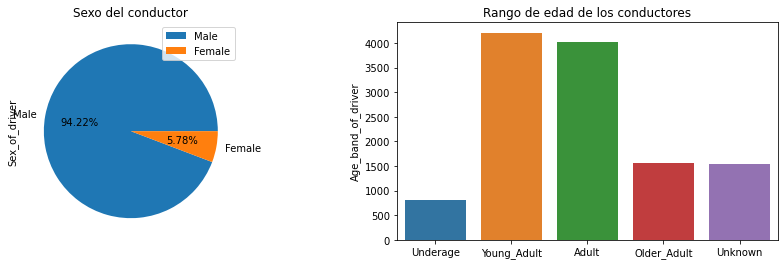

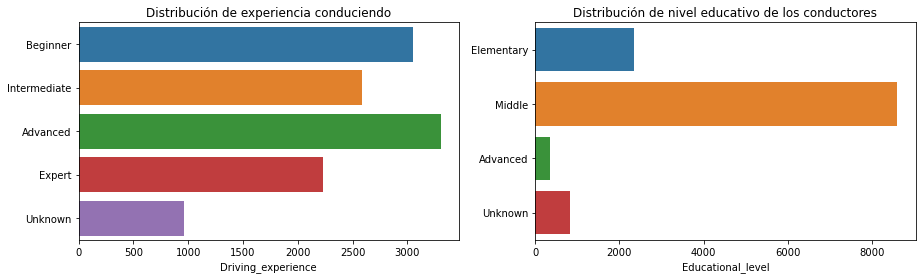

In [10]:
# Ordenamos rangos de edad
sorted_age_ranges = pd.DataFrame(data['Age_band_of_driver'].value_counts())
sorted_age_ranges["order"] = [2,3,4,5,1]
sorted_age_ranges = sorted_age_ranges.sort_values("order")

plt.subplots(2,2,figsize=(15,4))

# Sexo of driver
plt.subplot(1, 2, 1)
plot = data['Sex_of_driver'].value_counts().plot(kind='pie', autopct='%.2f%%', title="Sexo del conductor")
plot.legend(data['Sex_of_driver'].value_counts().index)

# Age band of driver
plt.subplot(1, 2, 2)
x_labels = data["Age_band_of_driver"].unique()
sns.barplot(x=sorted_age_ranges.index, y="Age_band_of_driver", data=sorted_age_ranges).set(title="Rango de edad de los conductores")

plt.subplots(2,2,figsize=(15,4))

# Experiencia del conductor
sorted_exp = pd.DataFrame(data['Driving_experience'].value_counts())
sorted_exp["order"] = [2, 0, 1, 3, 4]
sorted_exp = sorted_exp.sort_values("order")

plt.subplot(1, 2, 1)
sns.barplot(y=sorted_exp.index, x="Driving_experience", data=sorted_exp).set(title="Distribución de experiencia conduciendo")

# Nivel de educación
sorted_ed = pd.DataFrame(data['Educational_level'].value_counts())
sorted_ed["order"] = [1, 0, 3, 2]
sorted_ed = sorted_ed.sort_values("order")

plt.subplot(1, 2, 2)
sns.barplot(data=sorted_ed, x="Educational_level", y=sorted_ed.index).set(title="Distribución de nivel educativo de los conductores")

Vemos que la mayoría de los accidentes son ocasionados por un conductor con las siguientes características: 
* es hombre, 
* su rango etario es entre 18-60 años (adulto o adulto jóven),
* su experiencia conduciendo es de nivel avanzado, aunque en segundo puesto se encuentren conductores con un nivel de principiante, y
* tiene un nivel de educación media.

A continuación vamos a análizar cómo las condiciones del suelo y del camino se relacionan con la gravedad de los accidentes.

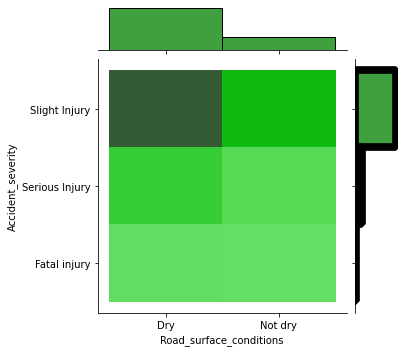

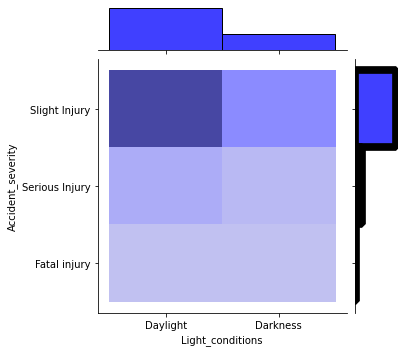

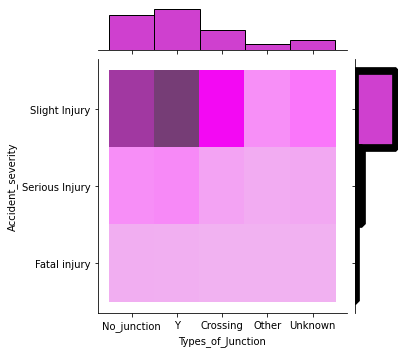

In [11]:
# Condiciones del suelo
sns.jointplot(x="Road_surface_conditions", y="Accident_severity", data=data, kind="hist", color="g", height=5)

# Condiciones de luz
sns.jointplot(x="Light_conditions", y="Accident_severity", data=data, kind="hist", color="b", height=5)

# Tipo de intersección
sns.jointplot(x="Types_of_Junction", y="Accident_severity", data=data, kind="hist", color="m", height=5)

Se observa que en los tres gráficos, la mayoría de los registros se encuentran asociados a accidentes de severidad baja. Esto tiene sentido ya que la clase mayoritaria en la variable objetivo es `Slight injury`. Más allá de eso pasamos a analizar cómo se relacionan las diferentes categorías de cada una de las features seleccionadas:
* En cuanto a si el camino se encontraba en condiciones mojadas o secas: Mientras que para los casos de accidentes fatales no se observa una diferencia apreciable, tanto para los accidentes de nivel "serio" o "bajo", se nota que la mayoría de los accidentes ocurren en condiciones donde la ruta se encontraba seca. Esto también coincide con el hecho de que la mayoría de los registros de nuestro dataset pertenecen a la clase "seca".

* En el caso de las condiciones lumínicas de la ruta: Ocurre una situación parecida al caso anterior. Para los casos de accidentes fatales no se observa una diferencia apreciable entre las dos categorías, mientras que para los accidentes de nivel "serio" o "bajo" se nota que la mayoría de los accidentes ocurren en condiciones donde había luz natural. Esto también coincide con el hecho de que la mayoría de los registros de nuestro dataset pertenecen a la clase "con luz".

* Por último, en cuanto al tipo de cruce donde ocurrió el accidente: Se encuentra una mayoría sostenida en los tres tipos de accidentes donde no había un cruce o donde había un cruce del tipo Y. En el caso de los accidentes leves se observa una clara diferencia en la frecuencia de accidentes en los distintos tipos de cruces: en primer lugar, la mayoría se dieron en cruces del tipo Y, seguido por ocasiones donde no había un cruce, y finalmente un cruce común. Las categorías minoritarias para este tipo de accidentes son aquellos donde se desconoce el tipo de cruce y donde el cruce era de otro tipo.

En los siguientes gráficos analizaremos cómo se relacionan algunas de las variables vistas anteriormente, pero acontando el espectro de datos a aquellos vinculados a accidentes catalogados como `Fatal injury`. 

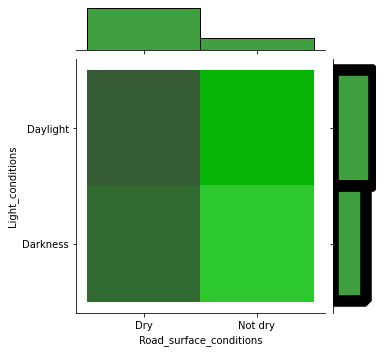

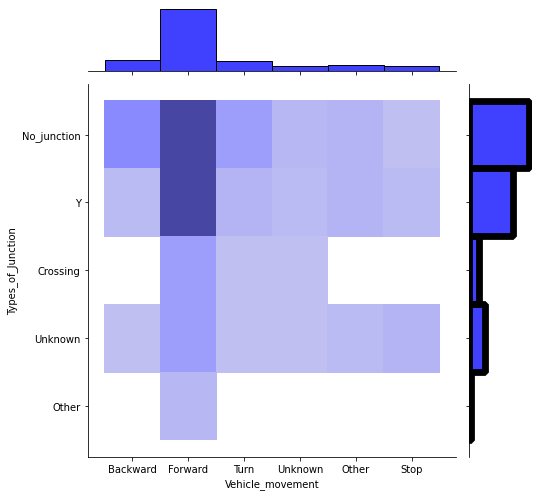

In [12]:
# Accidentes de gravedad fatal
data_fatal_sev = data[data["Accident_severity"] == 'Fatal injury']

# Condiciones del suelo & Condiciones de luz
sns.jointplot(x="Road_surface_conditions", y="Light_conditions",data=data_fatal_sev, kind="hist", color="g", height=5)
# Condiciones del suelo y tipo de intersección
sns.jointplot(x="Vehicle_movement", y="Types_of_Junction", data=data_fatal_sev, kind="hist", color="b", height=7)

Se observa que los accidentes de severidad fatal tienen una mayor frecuencia los días donde la ruta se encuentra seca, particularmente durante el día, aunque también son frecuentes durante la noche. Extrañamente, la situación con menor cantidad de accidentes de severidad fatal es durante la noche, cuando la ruta se encuentra mojada.

En contraste con los accidentes totales, los accidentes fatales suceden con mayor frecuencia en caminos sin ningun tipo de intersección, y después en aquellos con intersección tipo _Y_. Si comparamos el movimiento que estaba realizando el vehículo con el tipo de cruce en el que se encontraba, observamos que la mayoría de los accidentes fatales se dan en las condiciones donde:
    
   - el vehículo se encontraba avanzando hacia adelante, y
   - no había un cruce o había uno de tipo _Y_
    
Por otra parte, se observa una cantidad nula de accidentes en las ocasiones donde el tipo de cruce es "otro" (salvo cuando el vehículo está avanzando) y en los casos donde el vehículo se encuentra en un cruce común, ya sea estacionado, retrocediendo, o realizando un movimiento que no es, ni avanzando, ni girando.


Ahora analizaremos cómo se relaciona otro par de features referentes al tipo de vehículos y objetos involucrados en el accidente.

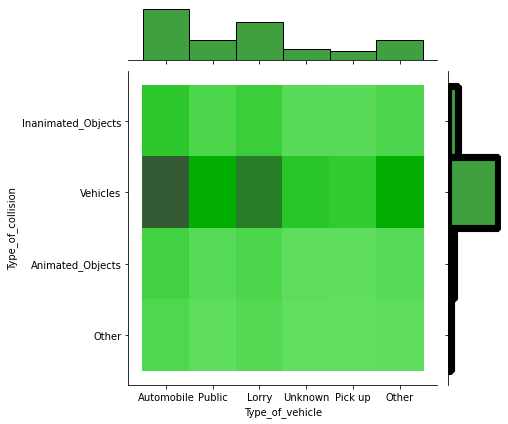

In [13]:
# Tipo de vehiculo & tipo de choque
sns.jointplot(x="Type_of_vehicle", y="Type_of_collision", data=data, kind="hist", color="g", height=6)

En todos los casos, independientemente del tipo de vehículo involucrado en el accidente, el elemento contra el que se genera una mayor cantidad de incidentes es contra otro vehículo. Por otro lado, el elemento contra el que se genera una menor cantidad de accidentes parecen ser aquellos que caen en la categoría "otros". Los accidentes ocurren principalmente en automoviles y camiones particulares, seguidos por las unidades de trasporte público (de distintos tipos), y "otros". 

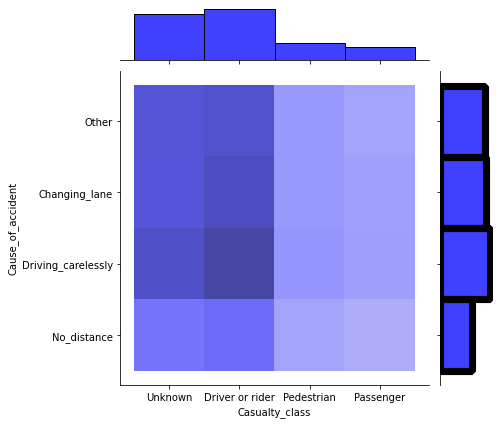

In [14]:
# Causa y tipo de suceso
sns.jointplot(x="Casualty_class", y="Cause_of_accident", data=data, kind="hist", color="b", height=6)

Se identifica claramente que _manejar descuidadamente_ es la principal causa de los accidentes, mientras que la _falta de distancia entre vehículos_ es la menos frecuente.

En general se observa que, sin importar cuál fue la causa del accidente, la persona que se accidenta con mayor frecuencia suele ser el conductor o algún elemento catalogado como "unknown". Por otra parte, las personas que se ven menos afectadas son los peatones y los pasajeros a bordo del vehículo involucrado.

[Text(0.5, 1.0, 'Distribución de tipos de colisiones en accidentes fatales')]

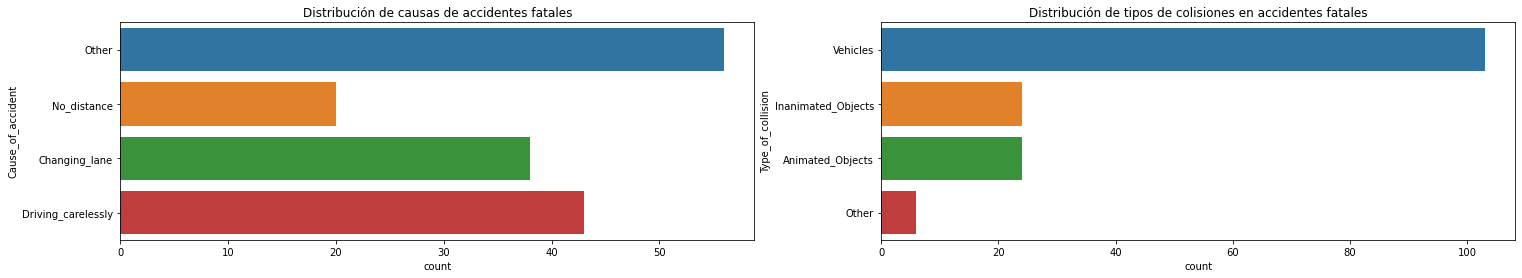

In [15]:
# Causa y tipo de choque en accidentes fatales
f, axes = plt.subplots(1, 2, figsize=(25,4))
# Causa en accidentes fatales
sns.countplot(y="Cause_of_accident", data=data_fatal_sev, ax=axes[0]).set(title="Distribución de causas de accidentes fatales")
sns.countplot(y="Type_of_collision", data=data_fatal_sev, ax=axes[1]).set(title="Distribución de tipos de colisiones en accidentes fatales")

Si observamos la _causa_ y el _tipo de colision_ de los accidentes considerados como fatales, la mayoría de estos se deben a una causa diferente a aquella vista para el dataset en general. En este caso la causa principal de los accidentes corresponde a la categoría "otro", donde los accidentes no se deben a la falta de distancia entre vehículos, ni a un cambio de carril, ni a manejar descuidadamente. Por otra parte, observamos que el tipo de colisión que suele llevar a un accidente fatal es la misma que para los accidentes en general: colisión entre dos o más vehículos.

Nuestro dataset cuenta con 14 variables de tipo int. Analizaremos cómo se distribuyen algunos de los valores de las mismas:

Text(0.5, 1.0, 'Number of casualties')

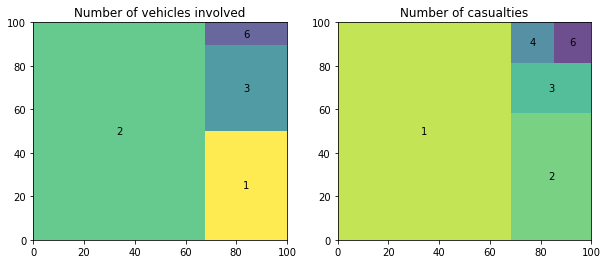

In [16]:
plt.subplots(1, 2, figsize=(10,4))
# Número de vehículos y número de heridos
num_veh = data_num['Number_of_vehicles_involved'].value_counts()
num_cas = data_num['Number_of_casualties'].value_counts()

plt.subplot(1, 2, 1)
squarify.plot(sizes=num_veh, label=num_veh.index, alpha=.8)
plt.title("Number of vehicles involved")

plt.subplot(1, 2, 2)
squarify.plot(sizes=num_cas, label=num_cas.index, alpha=.8)
plt.title("Number of casualties")

Del gráfico de la izquierda observamos que los accidentes suceden comunmente entre dos vehículos, mientras que los accidentes entre 6 o más son ocasionales. Por otra parte, si miramos el gráfico de la derecha, notamos que tener varias personas accidentadas no es lo más común, si no que, en general de los accidentes resulta un único herido. Para analizar la gravedad de los heridos veamos el siguiente gráfico.

[Text(0.5, 1.0, 'Distribución de severidad del accidentado en accidentes fatales')]

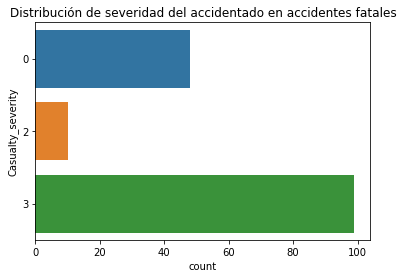

In [17]:
# gravedad de los heridos en accidentes fatales
sns.countplot(y="Casualty_severity", data=data_fatal_sev).set(title="Distribución de severidad del accidentado en accidentes fatales")

La severidad de los heridos se representa con valores numéricos, donde 0 significa menor severidad y 3 significa mayor severidad. Con este gráfico podemos corroborar que efectivamente en los accidentes clasificados como fatales, la mayoría de las personas accidentadas terminan gravemente heridas. Lo interesante de este gráfico es que la severidad tipo _0_ presenta mayor frecuencia que en la severidad tipo _2_. Esto quiere decir que mayormente, los heridos resultan o muy graves, o ligeramente graves, y solo ocasionalmente presentan heridas de severidad media.

Finalmente, observemos la correlación entre las variables numéricas.

Text(0.5, 1.0, 'Correlación entre variables numéricas')

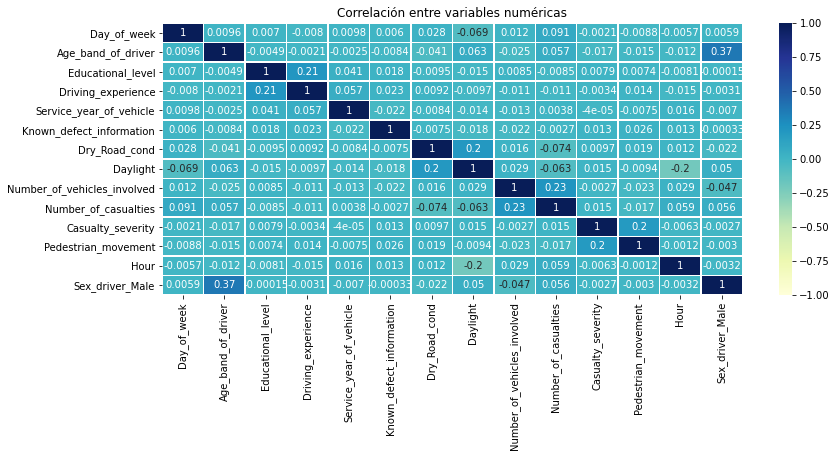

In [18]:
# Correlación de variables 
fig, ax = plt.subplots(figsize=(13,5))
sns.heatmap(data_num.corr(), annot=True, vmin=-1, cmap="YlGnBu", linewidths=.5)
ax.set_title("Correlación entre variables numéricas")

Se observa que en general la correlación entre estas variables es baja, en algunos casos positiva y en otros negativa. Las variables que presentan mayor correlación son `Sex_driver_Male` con `Age_band_of_driver`, `Driving_experience` con `Educational_level`, `Number_of_casualties` con `Number_of_vehicles_involved`.

Pasamos a calcular la varianza de las variables numéricas:

In [19]:
variance = pd.DataFrame({"Varianza": data_num.var()})
variance.index = data_num.var().index
variance.sort_values(["Varianza"], ascending=False)

,Varianza
Hour,27.082388
Day_of_week,3.731156
Casualty_severity,1.998756
Service_year_of_vehicle,1.543863
Driving_experience,1.524892
Age_band_of_driver,1.347283
Number_of_casualties,1.121769
Number_of_vehicles_involved,0.819657
Educational_level,0.405934
Known_defect_information,0.230056


Observamos que la feature con mayor varianza es `Hour` (con un valor de 27.08), seguido por `Day_of_week` y `Casualty_severity`; por otra parte `Sex_driver_Male` y `Pedestrian_movement` son las que menos varianza poseen. Asi como una varianza alta puede indicar que una variable es relevante, una varianza cercana a 0 indica lo contrario. En esta instancia del trabajo decidimos no eliminar las features con menor varianza para poder realizar posteriormente un análisis de feature importance.

---
<a id="m3"></a> 
## Módulo 3 - Variables dummies y Balance de clases
[Ir a índice](#contenido)

En este momento contamos con un dataset que contiene tanto variables numéricas como categóricas, donde además la variable objetivo se encuentra desbalanceada. 

Dado el desbalance de las clases de `Accident_severity`, utilizaremos un método de resampling para balancearlas. Recordemos que tenemos dos tipos de resampling: Aumentando los casos de la clase minoritaria (**oversampling**) y descartando casos de la clase mayoritaria (**undersampling**). Decidimos utilizar _oversampling_ para poder conservar la mayor cantidad de registros para utilizar en el entrenamiento de los modelos, lo cual permitirá que estos desarrollen una mejor capacidad de generalización. De utilizar undersampling, el modelo se vería limitado a aprender a partir de un conjunto reducido de registros.

In [20]:
data = pd.read_csv("RTA_clean_model.csv", index_col=False)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12138 entries, 0 to 12137
Data columns (total 23 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Day_of_week                  12138 non-null  int64 
 1   Age_band_of_driver           12138 non-null  int64 
 2   Educational_level            12138 non-null  int64 
 3   Vehicle_driver_relation      12138 non-null  object
 4   Driving_experience           12138 non-null  int64 
 5   Type_of_vehicle              12138 non-null  object
 6   Service_year_of_vehicle      12138 non-null  int64 
 7   Known_defect_information     12138 non-null  int64 
 8   Lanes_or_Medians             12138 non-null  object
 9   Types_of_Junction            12138 non-null  object
 10  Dry_Road_cond                12138 non-null  int64 
 11  Daylight                     12138 non-null  int64 
 12  Type_of_collision            12138 non-null  object
 13  Number_of_vehicles_involved  12

Notemos que nuestro dataset se compone por 9 variables categóricas y 14 variables numéricas.

### 3.1 Variables dummies

Antes de aplicar el `RandomOverSampler`, necesitamos generar las variables dummies para los datos categóricos. Aprovechamos para unificar las dos variables minoritarias para simplificar la complejiidad del problema a resolver.

In [21]:
data['Accident_severity'] = ["Serious Injury" if entry == 'Fatal injury' else entry for entry in data['Accident_severity']]
data['Accident_severity'].value_counts(normalize=True)

Slight Injury     0.84495
Serious Injury    0.15505
Name: Accident_severity, dtype: float64

In [22]:
X = pd.get_dummies(data.drop(columns="Accident_severity"))
y = data['Accident_severity']

### 3.2. Oversampling

Separamos los datos en los conjuntos de train y test para posteriormente generar el oversampling.

NOTA: _No aplicamos oversampling a los datos de X_test e y_test ya que estos datos nos sirven únicamente para evaluar la performance de nuestro algoritmo. Es decir, aplicamos oversampling a los datos de entrenamiento para que el modelo tenga a disposición una mayor cantidad de datos a partir de los cuales pueda aprender y generalizar_

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2, random_state=123)

In [24]:
# Realizamos el oversampling a los conjuntos de entrenamiento
oversampler = RandomOverSampler(sampling_strategy='minority', random_state=42)
X_train_oversamp, y_train_oversamp = oversampler.fit_resample(X_train, y_train)

In [25]:
print("CON VARIABLES DUMMIES----------")
print('Tamaño de datasets ANTES del oversampling:')
print("X_train = ", X_train.shape)
print("y_train = ", y_train.shape)
print("X_test = ", X_test.shape)
print("y_test = ", y_test.shape)

print('\nTamaño de dataset DESPUÉS del oversampling:')
print("X_train_oversamp = ", X_train_oversamp.shape)
print("y_train_oversamp = ", y_train_oversamp.shape)
print("X_test = ", X_test.shape)
print("y_test = ", y_test.shape)

CON VARIABLES DUMMIES----------
Tamaño de datasets ANTES del oversampling:
X_train =  (9710, 51)
y_train =  (9710,)
X_test =  (2428, 51)
y_test =  (2428,)

Tamaño de dataset DESPUÉS del oversampling:
X_train_oversamp =  (16408, 51)
y_train_oversamp =  (16408,)
X_test =  (2428, 51)
y_test =  (2428,)


Observamos que una vez hecho el oversampling, las tres clases dentro de nuestra variable objetivo tienen la misma proporción.

In [26]:
print('Balance de clases ANTES del oversampling:')
print(y_train.value_counts(normalize=False))
print('\nBalance de clases DESPUÉS del oversampling:')
print(y_train_oversamp.value_counts(normalize=False))

Balance de clases ANTES del oversampling:
Slight Injury     8204
Serious Injury    1506
Name: Accident_severity, dtype: int64

Balance de clases DESPUÉS del oversampling:
Serious Injury    8204
Slight Injury     8204
Name: Accident_severity, dtype: int64


Guardamos una nueva versión de los datos.

In [27]:
# Generamos una nueva versión del dataset
X_train_oversamp.to_csv("RTA_oversamp_X_train.csv", index=False)
y_train_oversamp.to_csv("RTA_oversamp_y_train.csv", index=False)

X_test.to_csv("RTA_oversamp_X_test.csv", index=False)
y_test.to_csv("RTA_oversamp_y_test.csv", index=False)

---
<a id="m4"></a> 
## Módulo 4 - Modelos de Machine Learning
[Ir a índice](#contenido)
   - [4.1. Modelo de Regresión Logística](#mod_reg_log)
   - [4.2. Modelo Random forest](#random_forest)
   - [4.3. Modelo Gradient Boosting](#gradient_boosting)
   - [4.4. Modelo XGBoost](#xgboost)
   

En este módulo aplicaremos **cuatro** modelos de clasificación. Inicialmente utilizaremos todas las features y evaluaremos su importancia para determinar cuales son las condiciones que más influyen en la clasificación de severidad de los accidentes. Partimos con los conjuntos Train y Test resultantes en el módulo anterior.

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn import tree
from IPython.display import Image
import pydotplus
from scikitplot.metrics import plot_roc

In [29]:
X_train = pd.read_csv("RTA_oversamp_X_train.csv", index_col=False)
y_train = pd.read_csv("RTA_oversamp_y_train.csv", index_col=False)['Accident_severity']

X_test = pd.read_csv("RTA_oversamp_X_test.csv", index_col=False)
y_test = pd.read_csv("RTA_oversamp_y_test.csv", index_col=False)['Accident_severity']


print("Tamaños de los dataset:")
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

Tamaños de los dataset:
(16408, 51)
(16408,)
(2428, 51)
(2428,)


Dado que algunos de los modelos requieren los conjuntos `X` estandarizados, vamos a generar la versión estandarizada de `X_train` y `X_test` . Dependiendo del modelo, utilizaremos los conjuntos
 * `X_train` y `X_test`, o
 * `X_train_std` y `X_test_std`
 
como conjuntos de features para ajustar y evaluar el modelo.

In [30]:
# Solo estandarizamos el conjunto con variables dummies
scaler = StandardScaler()  
X_train_std = scaler.fit_transform(X_train)   
X_test_std = scaler.transform(X_test)

---
En el siguiente módulo haremos un comparativo de los resultados obtenidos en cada modelo, para ello, definimos el DataFrame `results` donde, por cada modelo evaluado, guardaremos el registro de:
 * **Modelo:** Una breve descripción del modelo que se evalúa
 * **Accuracy:** Métrica de desempeño del modelo
 * **ROC AUC score:** Métrica de desempeño del modelo
 
_**Nota:** Las métricas serán obtenidas a partir del conjunto de datos de entrenamiento ya que reservaremos el conjunto de testeo para hacer la evaluación final del algoritmo seleccionado. Y solo en este último caso analizaremos detalladamente el reporte de clasificación con las métricas de desempeño del modelo, incluyendo aquellas globales y particulares para cada clase._

En este trabajo, consideramos que recall (_sensibilidad o tasa de verdaderos positivos_) y accuracy (_exactitud_) son unas de las métricas más importantes para medir el rendimiento de los modelos.

La métrica **_accuracy_** representa la proporción de casos correctamente clasificados. Esta  se ve influenciada por el balance de clases en el dataset debido a que hace foco tanto en la detección correcta de verdaderos negativos como de verdaderos positivos. Es por esta razón que su uso más común es cuando se trabaja con un dataset balanceado. En nuestro caso accuracy resulta ser una métrica confiable ya que se realizó un trabajo de oversampling, logrando balancear las clases.

Por otra parte, el **_recall_** mide la capacidad o sensibilidad del modelo de detectar los verdaderos positivos sobre todos los casos que son positivos. Esta métrica funciona mejor cuando se trabaja con datasets desbalanceados ya que no se ve afectada por los problemas de desbalanceo de clases.

La métrica **ROC AUC** nace a partir de la curva ROC. Esta última permite evaluar en un modelo la relación entre la tasa de falsos negativos (_especificidad_) y la tasa de verdaderos positivos (_sensibilidad o recall_) para distintos umbrales de decisión. La métrica ROC AUC representa el área bajo la curva de la curva ROC. Su trabajo es intentar resumir en una sola métrica la relación que muestra el gráfico entre la sensibilidad y la especificidad para poder comparar diferentes modelos. Vale aclarar que dos modelos con un mismo valor ROC AUC pueden tener una curva ROC diferente.

In [31]:
# Generamos un dataframe donde vamos a contabilizar los resultados de cada modelo
results = pd.DataFrame(columns=['Model', 'Accuracy', 'ROC_AUC'])

Ajustaremos los siguientes modelos de clasificación utilizando _Cross Validation_ para obtener un accuracy promedio de desempeño del modelo, y _GridSearch_ para evaluar distintas combinaciones de hiperparámetros:
* Regresión Logística
* RandomForest
* GradientBoosting
* XGBoosting

Utilizamos la función `evaluate_model` para evaluar el desempeño de los modelos tanto en con el conjunto de entrenamiento como el de test.

In [32]:
def evaluate_model(model, X, y, nota, eval_test=False):
    
    # Aplicamos el modelo
    y_pred = model.best_estimator_.predict(X)
    
    # Generamos méticas de accuracy
    acc = accuracy_score(y, y_pred)
    roc_auc = roc_auc_score(y, model.best_estimator_.predict_proba(X)[:, 1])
    print("Accuracy = {}%".format((acc*100).round(2)))
    print("ROC AUC = {}%".format((roc_auc*100).round(2)))
    print("--------------------------------------------------------\n")
    
    # Generamos la matriz de confusion
    conf_matrix1 = confusion_matrix(y, y_pred, normalize="true")
    ax1 = sns.heatmap(conf_matrix1, annot=True, xticklabels = y_train.unique(), yticklabels = y_train.unique(), linewidths=.5, cmap="YlGnBu", fmt="g")
    ax1.set(xlabel='Prediction', ylabel='Ground truth', title="Confusion Matrix")

    if eval_test:
        # Mostramos reporte de métricas de evaluación
        print(classification_report(y, y_pred))
        print("--------------------------------------------------------")
        plot_roc(y, model.best_estimator_.predict_proba(X), plot_micro=False, plot_macro=False)

    # Registramos las métricas en el DataFrame "resultados"
    results.loc[len(results.index)] = [nota, acc, roc_auc]

---

<a id="mod_reg_log"></a>
### 4.1 Modelo de Regresión logística
[Ir al inicio del modulo 4](#m4)

Vamos a evaluar el modelo de Regresión Logística usando cross validation y la configuración de un modelo multi-clase. Utilizaremos las variables estandarizadas definidas al inicio de este módulo y el método GridSearch para evaluar distintas combinaciones de los parámetros.

Definimos la función `lr_grid_cv` que tiene como entradas los conjutos de train y test, así como una nota con la descripción del modelo.

In [33]:
def lr_grid_cv (X_train, y_train):
    
    # Instanciamos el modelo
    lr = LogisticRegression(multi_class='multinomial')
    
    # Definimos el espacio de parámetros que queremos testear
    parameter_space = {
        "C": [0.001, 0.01, 0.1, 0.5, 1, 1.5, 2], # Inverse of regularization strength
        "penalty":  ['l2'], # 'saga' - ['elasticnet', 'l1', 'l2', 'none'] 
        'class_weight': ['balanced', None]
    }

    # Definimos el método de validación cruzada con el método StratifiedKFold
    folds = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

    # Definimos el metodo de busqueda y la métrica de evaluación = accuracy
    grid = GridSearchCV(estimator=lr, param_grid=parameter_space, 
                        cv=folds, scoring='accuracy', n_jobs=4)
    
    # Ajustamos el modelo
    grid.fit(X_train, y_train)
    
    # Mostramos el conjunto de parámetros con mejor score
    print("--------------------------------------------------------")
    print("El mejor conjunto de parámetros es: \n ", grid.best_params_)
    print("\nCV best accuracy: {}%\n".format((grid.best_score_*100).round(2)))
    
    return grid

--------------------------------------------------------
El mejor conjunto de parámetros es: 
  {'C': 0.01, 'class_weight': None, 'penalty': 'l2'}

CV best accuracy: 57.2%

Accuracy = 58.15%
ROC AUC = 60.52%
--------------------------------------------------------



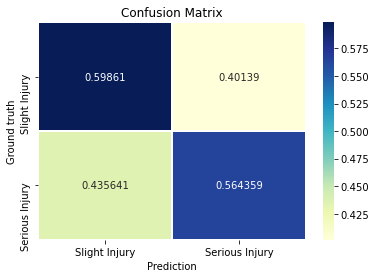

In [34]:
model = lr_grid_cv(X_train_std, y_train)
evaluate_model(model, X_train_std, y_train, nota= "Regresión Logística")

Con un regresor logístico conseguimos un accuracy de entrenamiento aproximadamente del 58%. La matriz de confusión muestra la mayoría de los predicciones sobre la diagonal principal, lo cual es un buen indicador.

<a id="random_forest"></a> 
### 4.2 Modelo Random Forest
[Ir al inicio del modulo 4](#m4)

Random Forest es un modelo de ensamble de tipo **bagging**, lo que significa que construye varios estimadores de forma independiente y luego hace un _"promedio"_ de sus predicciones. Es una forma de promediar múltiples árboles de decisión profundos, entrenados con diferentes partes del mismo set de entrenamiento, con el objetivo de reducir la varianza. El modelo resultante del ensamble suele ser mejor que cualquier estimador base por separado. Aquí usamos un modelo **Random Forest Classifier** con validación cruzada. 

Definimos la función `random_forest` que tiene como entradas los conjuntos de train y test, y una nota con la descripción del modelo. Este modelo requiere tener los datos estandarizados por lo que utlizaremos aquellos que fueron definidos al inicio del módulo.

Al aplicar _GridSearch_ consideramos los siguientes hiperparámetros:
* **n_estimators:** El número de árboles con los que entrena el modelo
* **criterion:** El criterio para definir la calidad de una división de árbol
* **max_depth:** La máxima profundidad de cada árbol (si no se especifica, el árbol se expande hasta conseguir hojas puras)
* **min_samples_split:** El número mínimo de muestras requeridas para separar un nodo
* **class_weight:** Las especificaciones de peso de las clases

In [35]:
def random_forest(X_train, y_train):
    
    # Instanciamos el modelo
    rf_model = RandomForestClassifier(bootstrap=True, random_state=123)
    
    # Definimos el espacio de parámetros que queremos testear
    parameter_space = {
        'n_estimators':[2, 5, 10], 
        'criterion': ['gini', 'entropy'],
        'max_depth': [1, 2, 3, 4, 5],
        'class_weight': [None, 'balanced'],
        'random_state': [42]}

    # Definimos el método de validación cruzada con el método StratifiedKFold
    folds = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

    # Definimos el método de búsqueda
    grid = GridSearchCV(estimator=rf_model, param_grid=parameter_space, 
                        cv=folds, scoring='accuracy', n_jobs=-1)
    
    # Ajustamos el modelo
    grid.fit(X_train, y_train)
    
    # Identificamos el parámetro con mejor score y los principales resultados
    print("--------------------------------------------------------")
    print("El mejor conjunto de hiperparámetros es: \n ", grid.best_params_)
    print("\nCV best accuracy: {}%\n".format((grid.best_score_*100).round(2)))
    
    return grid

--------------------------------------------------------
El mejor conjunto de hiperparámetros es: 
  {'class_weight': None, 'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 10, 'random_state': 42}

CV best accuracy: 62.31%

Accuracy = 63.5%
ROC AUC = 69.64%
--------------------------------------------------------



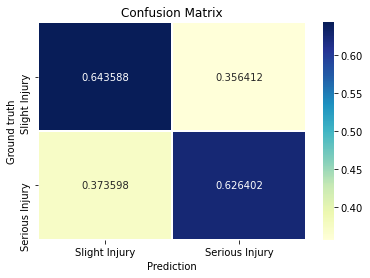

In [36]:
model = random_forest(X_train_std, y_train)
evaluate_model(model, X_train_std, y_train, nota="Random Forest")

En este caso obtenemos un accuracy de 63.50%, donde se observa que la diagonal principal mantiene la mayoría de las predicciones. Sin embargo se observa que el modelo está teniendo varios falsos positivos donde clasifica `Serious injury` cuando en realidad corresponde a la categoría `Slight injury`.

In [37]:
# IMPORTANCIA DE FEATURES
pd.DataFrame({"Feature": X_train.columns, 
              "Importance": model.best_estimator_.feature_importances_}).sort_values(by="Importance", ascending=False)

,Feature,Importance
8,Number_of_vehicles_involved,0.225951
12,Hour,0.111513
9,Number_of_casualties,0.089666
1,Age_band_of_driver,0.071417
28,Types_of_Junction_Crossing,0.065421
0,Day_of_week,0.060351
3,Driving_experience,0.027836
2,Educational_level,0.023684
29,Types_of_Junction_No_junction,0.022533
6,Dry_Road_cond,0.018246


Observamos que las dos features mas importantes son `Number_of_vehicles_involved` y `Hour`. Por otra parte, las primeras 5 variables más importantes son todas numéricas, salvo por `Types_of_Junction_Crossing`, la cual originalmente es categórica. Por último, las 5 variables menos importantes son todas variables originalmente categóricas que fueron transformadas en dummies.

### <a id="gradient_boosting"></a> 
### 4.3 Gradient boosting
[Ir al inicio del modulo 4](#m4)

Boosting es una técnica de ensamble en la que el entrenamiento es secuencial, trabaja de manera iterativa y va construyendo un modelo final en pasos. En cada nuevo paso intentará aprender de los errores cometidos en los pasos previos. Se entrena una secuencia de modelos donde se da más peso a los ejemplos que fueron clasificados erróneamente por iteraciones anteriores. Trabaja sobre dichos errores, los usa para cambiar la ponderación en el siguiente modelo o bien entrenando un modelo que prediga los mismos. Al igual que con bagging, las tareas de clasificación se resuelven con una mayoría ponderada de votos.

Definimos la función `gb_grid_cv` que tiene como entradas los conjuntos de train y test, y una nota con la descripción del modelo. Este modelo *no* requiere tener los datos estandarizados.

Al aplicar GridSearch consideramos los siguientes hiperparámetros:

- `learning_rate`: un numero bajo de Learning rate asegura convergencia del descenso del gradiente, pero aumenta los tiempos de entrenamiento. Como mencionamos anteriormente, a medida que se reduce el valor de $\eta$ es recomendable aumentar el número de estimadores N.
- `n_estimators`: cantidad de estimadores que se van a utilizar
- `max_depth`: la pronfundidad máxima del árbol
- `min_samples_leaf`: el número mínimo de n_samples para constituir una hoja del árbol (nodo terminal)
- `min_samples_split`: el número mínimo de n_samples para realizar un split.

In [38]:
from sklearn.ensemble import GradientBoostingClassifier
def gb_grid_cv (X_train, y_train):
    
    # Instanciamos el modelo
    gb = GradientBoostingClassifier(random_state=42)
    
    # Definimos el espacio de parámetros que queremos testear
    parameter_space = {'n_estimators':[5, 10, 15] , 
                       'learning_rate':[0.75, 1, 1.5],
                       'min_samples_split': [1, 2, 3], 
                       'min_samples_leaf': [3, 4, 4], 
                       'max_depth': [3, 4, 5], 
                       'random_state': [42]
    }

    # Definimos el método de validación cruzada con el método StratifiedKFold
    folds = StratifiedKFold(n_splits=5, random_state=123, shuffle=True) #carlos sugiere n_splits=5

    # Definimos el metodo de busqueda y la métrica de evaluación = accuracy
    grid = GridSearchCV(estimator=gb, param_grid=parameter_space, 
                        cv=folds, scoring='accuracy', verbose=1, n_jobs=-1) 
    
    # Ajustamos el modelo
    grid.fit(X_train, y_train)
    
    # Mostramos el conjunto de parámetros con mejor score
    print("--------------------------------------------------------")
    print("El mejor conjunto de parámetros es: \n ", grid.best_params_)
    print("\nCV best accuracy: {}%\n".format((grid.best_score_*100).round(2)))
    
    return grid

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
--------------------------------------------------------
El mejor conjunto de parámetros es: 
  {'learning_rate': 1, 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 15, 'random_state': 42}

CV best accuracy: 73.93%

Accuracy = 79.31%
ROC AUC = 87.78%
--------------------------------------------------------



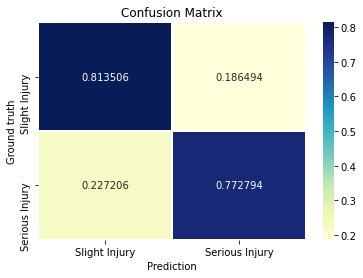

In [39]:
model = gb_grid_cv(X_train, y_train)
evaluate_model(model, X_train, y_train, nota="Gradient Boosting")

Observamos una mejora respecto al modelo anterior, ahora obtuvimos un accuracy de entrenamiento de casi del 80%. Otra vez se observa que la mayoría de las predicciones se encuentran en la diagnal principal de la matriz de confusión.

Pasamos a analizar el feature importance:

In [40]:
# IMPORTANCIA DE FEATURES
pd.DataFrame({"Feature": X_train.columns, 
              "Importance": model.best_estimator_.feature_importances_}).sort_values(by="Importance", ascending=False)

,Feature,Importance
12,Hour,0.142751
8,Number_of_vehicles_involved,0.107676
9,Number_of_casualties,0.092931
0,Day_of_week,0.091046
1,Age_band_of_driver,0.054117
3,Driving_experience,0.047089
4,Service_year_of_vehicle,0.031142
7,Daylight,0.029010
2,Educational_level,0.028264
32,Types_of_Junction_Y,0.026005


En este caso vuelve a ocurrir lo mismo que en el modelo anterior: Las dos features mas importantes son `Number_of_vehicles_involved` y `Hour`. Por otra parte, las primeras 5 variables más importantes son todas numéricas. Por último, las 5 variables menos importantes son todas variables originalmente categóricas que fueron transformadas en dummies; donde la última `Casualty_class_Driver or rider` fue puntuada con importancia nula. Esta variable podría ser eliminada para aliviar el costo computacional.

### <a id="xgboost"></a> 
### 4.4 Modelo XGBoost
[Ir al inicio del modulo 4](#m4)

XGBoost es es una implementación específica del método Gradient Boosting que usa aproximaciones más precisas para encontrar el mejor modelo de árbol. Emplea una serie de mejoras, las mas importantes son:
1. Calcula gradientes de segundo orden, que proporciona más información sobre la dirección de los gradientes y cómo llegar al mínimo de nuestra función de pérdida. 
2. Regularización L1 y L2, que mejora la generalización del modelo.

XGBoost hace el entrenamiento muy rápido y se puede paralelizar / distribuir entre clústeres.

Internamente, XGBoost representa todos los problemas como un caso de modelado predictivo de regresión que sólo toma valores numéricos como entrada. El hecho de trabajar sólo con datos numéricos es lo que hace que esta librería sea tan eficiente.

Definimos la función `xgboost` que tiene como entradas los conjuntos de train y test, y una nota con la descripción del modelo. Este modelo *no* requiere tener los datos estandarizados.

Al aplicar GridSearch consideramos los siguientes hiperparámetros:

- `learning_rate`: un numero bajo de Learning rate asegura convergencia del descenso del gradiente, pero aumenta los tiempos de entrenamiento. Como mencionamos anteriormente, a medida que se reduce el valor de $\eta$ es recomendable aumentar el número de estimadores N.
- `n_estimators`: cantidad de estimadores que se van a utilizar
- `criterion`: define el criterio de impureza para evaluar la calidad de las particiones
- `max_features`: la cantidad de features que extraerá para entrenar cada `base_estimator`. Por default es igual a `sqrt(X.shape[1])`
- `bootstrap` y `bootstrap_features`: controla si tanto los n_samples como las features son extraidos con reposición.
- `max_depth`: la pronfundidad máxima del árbol
- `min_samples_leaf`: el número mínimo de n_samples para constituir una hoja del árbol (nodo terminal)
- `min_samples_split`: el número mínimo de n_samples para realizar un split.

In [41]:
def XGBoost_function(X_train, y_train):
    
    # 1-Instanciamos el modelo
    model_xgboost = XGBClassifier(random_state=42)
    
    # 2-Definimos el espacio de parámetros que queremos testear
    parameter_space = {
        "n_estimators": [50, 100, 150],           # Number of boosted trees to fit.
        "max_depth": [3, 4, 5],                   # Maximum tree depth for base learners.
        "learning_rate": [0.1, 0.2, 0.3, 0.4],    # Boosting learning rate (xgb’s “eta”)
        "random_state": [42]
    }
    
    # 3-Definimos el método de validación cruzada con el método StratifiedKFold
    folds = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

    # 4-Definimos el método de búsqueda
    grid = GridSearchCV(estimator=model_xgboost, param_grid=parameter_space, 
                        cv=folds, scoring='accuracy', n_jobs=-1)
    
    # Ajustamos el modelo
    grid.fit(X_train, y_train)
    
    # Identificamos el parámetro con mejor score y los principales resultados
    print("El mejor conjunto de parámetros es: \n ", grid.best_params_)
    print("\nCV best accuracy:\n ", grid.best_score_, "\n")
    
    return grid

[18:12:16] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
El mejor conjunto de parámetros es: 
  {'learning_rate': 0.4, 'max_depth': 5, 'n_estimators': 150, 'random_state': 42}

CV best accuracy:
  0.8930401081253561 

Accuracy = 96.39%
ROC AUC = 99.49%
--------------------------------------------------------



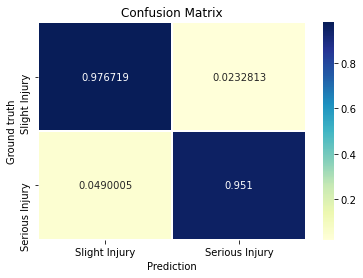

In [42]:
model = XGBoost_function(X_train, y_train)
evaluate_model(model, X_train, y_train, nota="XGBoost")

Observamos nuevamente una mejora respecto al modelo anterior, ahora obtuvimos un accuracy de entrenamiento aproximado del 96%. Otra vez se observa que la mayoría de las predicciones se encuentran en la diagnal principal de la matriz de confusión.

Pasamos a analizar el feature importance:

In [43]:
# IMPORTANCIA DE FEATURES
pd.DataFrame({"Feature": X_train.columns, 
              "Importance": model.best_estimator_.feature_importances_}).sort_values(by="Importance", ascending=False)

,Feature,Importance
8,Number_of_vehicles_involved,0.037980
28,Types_of_Junction_Crossing,0.025886
32,Types_of_Junction_Y,0.025643
9,Number_of_casualties,0.025437
7,Daylight,0.024931
33,Type_of_collision_Animated_Objects,0.024448
6,Dry_Road_cond,0.023346
29,Types_of_Junction_No_junction,0.022451
23,Lanes_or_Medians_Divided_Two-way,0.022312
0,Day_of_week,0.021939


En este caso observamos que deja de ocurrir lo observado en los modelos anteriores: la feature más importante es numérica (`Number_of_vehicles_involved`), pero las siguientes dos son originalmente categóricas convertidas a dummies (`Types_of_Junction_Crossing` y `Types_of_Junction_Y`). No obstante, para las 5 features menos importances se mantiene el mismo comportamiento: son todas variables dummies.

---
<a id="m5"></a> 
## Módulo 5: Comparación de resultados y conclusión
[Ir a índice](#contenido)

En esté modulo comparamos los resultados de los cuatro modelos. En la siguiente tabla podemos notar que el desempeño de los modelos fue mejorando, del 58.14% hasta el 96.38%, según el valor del accuracy obtenido, y sucede algo muy similar con el valor ROC_AUC.

In [44]:
# Mostramos resultados
results

,Model,Accuracy,ROC_AUC
0,Regresión Logística,0.581485,0.605161
1,Random Forest,0.634995,0.696422
2,Gradient Boosting,0.793150,0.877806
3,XGBoost,0.963859,0.994855


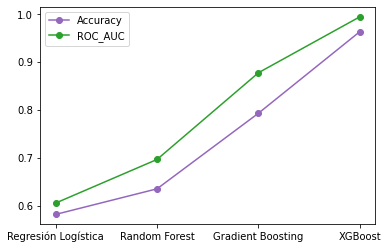

In [45]:
#graficamos el accuracy de los modelos
fig, ax = plt.subplots()
plt.plot(results["Model"], results["Accuracy"], color = 'tab:purple', marker = 'o', label = 'Accuracy')
plt.plot(results["Model"], results["ROC_AUC"],color = 'tab:green', marker = 'o', label = 'ROC_AUC')
ax.legend(loc = 'upper left')
plt.show()

Si comparamos los cuatro modelos generados, observamos que el XGBoost obtuvo un mejor rendimiento tanto en accuracy como en ROC AUC score, siendo estas de 96.39% y 99.49%.

### 5.1 Mejor modelo: XGBoost
[Ir al inicio del modulo 5](#m5)

De acuerdo con lo anterior, el mejor modelo fue **XGBoot** con los siguientes parámetros:
  * 'learning_rate': 0.4
  * 'max_depth': 5
  * 'n_estimators': 150

Vamos a evaluar su desempeño sobre el conjunto de test para obtener las métricas finales, conocer sus mejores 5 features, visualizar su curva ROC.

[18:13:33] WARNING: ..\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
El mejor conjunto de parámetros es: 
  {'learning_rate': 0.4, 'max_depth': 5, 'n_estimators': 150, 'random_state': 42}

CV best accuracy:
  0.8930401081253561 

Accuracy = 78.01%
ROC AUC = 66.94%
--------------------------------------------------------

                precision    recall  f1-score   support

Serious Injury       0.32      0.36      0.34       376
 Slight Injury       0.88      0.86      0.87      2052

      accuracy                           0.78      2428
     macro avg       0.60      0.61      0.60      2428
  weighted avg       0.79      0.78      0.79      2428

--------------------------------------------------------


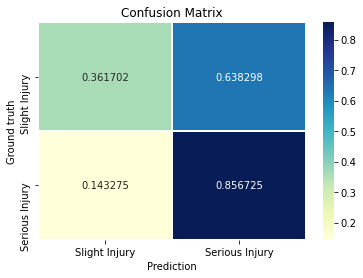

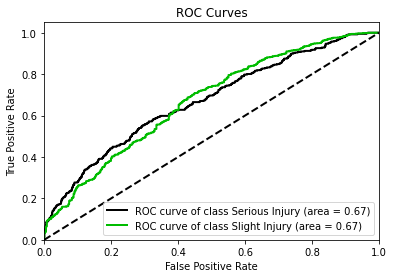

In [46]:
model = XGBoost_function(X_train, y_train)
evaluate_model(model, X_test, y_test, nota="XGBoost - TEST", eval_test=True)

Se observa que el rendimiento del algoritmo cayó al ser evaluado con el conjunto de datos de test. Ahora el accuracy bajó de 96.39% a 78.00% y el ROC AUC score de 99.49% a 66.94%. 

Es esperable que el rendimiento del modelo decaiga al ser evaluado en un conjunto de datos desconocidos. La amplia diferencia entre estos dos casos puede deberse a un sobreajuste por parte del modelo al conjunto de datos de entrenamiento.

Se observa que la curva ROC se mantiene cercana a la diagonal para ambas clases, lo que significa que nos encontramos lejos del escsenario ideal donde la tasa de verdaderos positivos toma valores cercanos a 1 (esquina superior izquierda). La curva correspondiente a _Serious_Injuri_ se mantiene por debajo de la crva _Slight Injuri_ cuando la tasa de falsos positivos es menor que 0.4. Después de este valor, las posiciones se invierten.

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

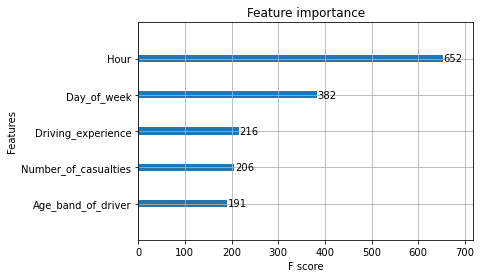

In [47]:
from xgboost import plot_importance
plot_importance(model.best_estimator_, max_num_features=5)

En cuanto a las features más importances para el entrenamiento del modelo, notamos que efectivamente aquellas que son numéricas poseen un mayor grado de influencia en el entrenamiento del modelo. Por otra parte resaltamos que, según el análisis realizado por el modelo, es importante conocer:

* A qué hora ocurrió el accidente
* En qué día de la semana
* La edad y experiencia del conductor
* La cantidad de accidentados a raiz del accidente

### 5.2 Conclusiones
[Ir al inicio del modulo 5](#m5)

Como resultado final identificamos un modelo que clasifica la gravedad de los accidentes como leve o seria, y a partir del cual identificamos las características más importantes de definen esta clasificación. Para poder aplícar el modelo fue muy importante realizar una limpieza de los datos originales, redefinir algunas features, y en algunos casos, convertirlas de variables categóricas a variables numéricas. Así mismo, el análisis exploratorio, previo a la aplicación de los modelos, resultó bastante útil para conocer mejor la estructura, familiarizarnos con los datos y agregar valor a la interpretación de resultados. 

Un aspecto muy importante fue la reducción de clases de la variable objetivo `Accident Severity`, pasando de 3 a dos opciones. Esto permitió balancear las clases y obtener mejores resultados en los modelos. También fue importante conocer cómo funciona cada modelo, que tipo de datos recibe como entradas y sobre que rangos se pueden definir sus parámetros. Todos estos aspectos influyen en su desempeño. Por otro lado, usar _GridSearch_ nos permitió ajustan una combinación de hipermarámetros adecuada para el modelo, ya que, a medida que incrementa la cantidad de parámetros y el rango de valores que puede tomar cada uno, el número de combinaciones incrementa rápidamente, y evaluar cada combinación manualmente no es una opción factible.

La información obtenida a lo largo de este análisis y aplicación de modelos nos resulta útil ya que nos permite tomar decisiones en cuánto a cuándo manejar, a que ciudadanos ofrecerles ciertos tipos de seguros, dónde y a quienes ponerles un mayor control en cuánto la habilitación del carnet de conducción, entre otras cosas.